In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Load Data

In [2]:
gr = pd.read_csv('official_goodreads_metadata.csv')
am = pd.read_csv('official_amazon_metadata.csv')

In [3]:
am_gr = pd.merge(gr, am[['asin', 'average']], how='inner', on='asin')

In [5]:
am_gr['rating_diff'] = am_gr['average'] - am_gr['average_rating']
am_gr = am_gr.drop(['average', 'average_rating', 'ratings_count', 'reviews_count', 'text_reviews_count', 'total_reviews_count', 
                    'publisher', 'description', 'cleaned_description'], axis=1)

In [6]:
col_names=["asin", "prop_topic_1", "prop_topic_2", "prop_topic_3", "prop_topic_4", 'prop_topic_5', 'prop_topic_6', 
           'prop_topic_7', 'prop_topic_8', 'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12', 'prop_topic_13',
           'prop_topic_14', 'prop_topic_15', 'delete']
lda_mallet = pd.read_csv('gr_LDA_wmallet_metadata.csv', names=col_names)
lda_mallet = lda_mallet.drop('delete', axis=1)
lda_mallet = pd.merge(lda_mallet, am_gr, on='asin', how='inner')

In [7]:
col_names=["asin", "prop_topic_1_desc", "prop_topic_2_desc", "prop_topic_3_desc", "prop_topic_4_desc", 'prop_topic_5_desc', 
           'prop_topic_6_desc', 'prop_topic_7_desc', 'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc', 
           'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc', 'prop_topic_14_desc', 'prop_topic_15_desc', 
           'delete']
lda_mallet_desc = pd.read_csv('gr_description_LDA_wmallet_step5_metadata.csv', names=col_names)
lda_mallet_desc = lda_mallet_desc.drop('delete', axis=1)
lda_mallet_desc = pd.merge(lda_mallet, lda_mallet_desc, on='asin', how='inner')

# Random Forest

### RF w/ numeric

In [11]:
lda_mallet_numeric = lda_mallet.drop(['cleaned_genres', 'format'], axis=1) 
lda_mallet_numeric = lda_mallet_numeric.dropna()

In [14]:
y = np.array(lda_mallet_numeric['rating_diff'])
x = lda_mallet_numeric.drop('asin', axis=1).drop('rating_diff', axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
model = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                             max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.1694112340225193
Mean Squared Error: 0.056197375139196475
Root Mean Squared Error: 0.2370598556044369
R2 Adjusted Score: 0.5031668363317059
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22276636522533477
Mean Squared Error: 0.09181105733766523
Root Mean Squared Error: 0.30300339492762324
R2 Adjusted Score: 0.1446822018963977


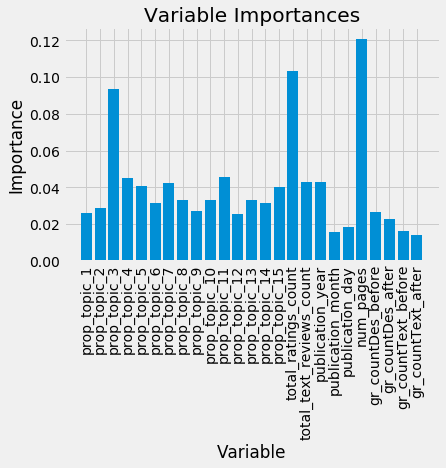

In [17]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### RF w/ desc

In [23]:
lda_mallet_desc_numeric = lda_mallet_desc.drop(['cleaned_genres', 'format'], axis=1) 
lda_mallet_desc_numeric = lda_mallet_desc_numeric.dropna()
lda_mallet_desc_numeric.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff', 'prop_topic_1_desc',
       'prop_topic_2_desc', 'prop_topic_3_desc', 'prop_topic_4_desc',
       'prop_topic_5_desc', 'prop_topic_6_desc', 'prop_topic_7_desc',
       'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc',
       'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc',
       'prop_topic_14_desc', 'prop_topic_15_desc'],
      dtype='object')

In [24]:
y = np.array(lda_mallet_desc_numeric['rating_diff'])
x = lda_mallet_desc_numeric.drop('asin', axis=1).drop('rating_diff', axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
model = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                             max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.16334309302784297
Mean Squared Error: 0.05270799189504847
Root Mean Squared Error: 0.22958221162591946
R2 Adjusted Score: 0.5337365646662213
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2222767226635001
Mean Squared Error: 0.09087439798098038
Root Mean Squared Error: 0.30145380737516053
R2 Adjusted Score: 0.15188022134593127


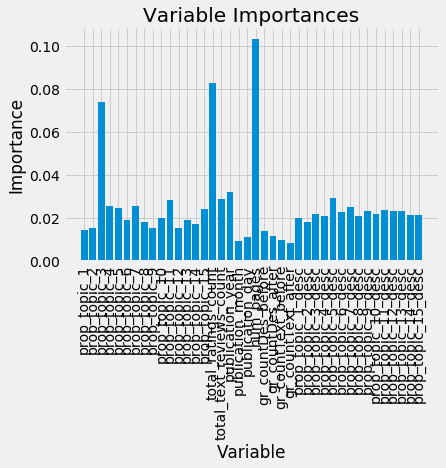

In [25]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### RF w/ genres

In [27]:
lda_mallet_desc_genres = lda_mallet_desc_numeric
am_gr['cleaned_genres'] = am_gr['cleaned_genres'].str.replace(' ','')
genres = pd.get_dummies(am_gr['cleaned_genres'].str.get_dummies(sep=','))
genres.astype('int8')
genres = pd.concat([genres, am_gr['asin']], axis=1)
lda_mallet_desc_genres = pd.merge(lda_mallet_desc_genres, genres, how='left', on='asin')
lda_mallet_desc_genres.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff', 'prop_topic_1_desc',
       'prop_topic_2_desc', 'prop_topic_3_desc', 'prop_topic_4_desc',
       'prop_topic_5_desc', 'prop_topic_6_desc', 'prop_topic_7_desc',
       'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc',
       'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc',
       'prop_topic_14_desc', 'prop_topic_15_desc', 'biography', 'children',
       'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historicalfiction',
  

In [28]:
y = np.array(lda_mallet_desc_genres['rating_diff'])
x = lda_mallet_desc_genres.drop('asin', axis=1).drop('rating_diff', axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
model = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                             max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.16252400378546364
Mean Squared Error: 0.052339844367348676
Root Mean Squared Error: 0.2287790295620398
R2 Adjusted Score: 0.5366969211697463
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2212730590838635
Mean Squared Error: 0.09026299865968647
Root Mean Squared Error: 0.3004380113429166
R2 Adjusted Score: 0.15596142854120454


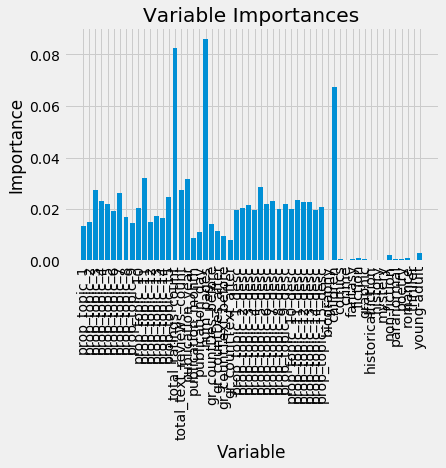

In [30]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### RF w/ format

In [29]:
lda_mallet_desc_format = lda_mallet_desc_numeric
form = pd.get_dummies(am_gr['format'].str.get_dummies(sep=','))
form.astype('int8')
form = pd.concat([form, am_gr['asin']], axis=1)
lda_mallet_desc_format = pd.merge(lda_mallet_desc_format, form, how='left', on='asin')
lda_mallet_desc_format.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff', 'prop_topic_1_desc',
       'prop_topic_2_desc', 'prop_topic_3_desc', 'prop_topic_4_desc',
       'prop_topic_5_desc', 'prop_topic_6_desc', 'prop_topic_7_desc',
       'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc',
       'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc',
       'prop_topic_14_desc', 'prop_topic_15_desc', ' ebook', 'Audible Audio',
       'Audio', 'Audio CD', 'Audio CD (Unabridged)', 'Audio Cassette',
       'A

In [31]:
y = np.array(lda_mallet_desc_format['rating_diff'])
x = lda_mallet_desc_format.drop('asin', axis=1).drop('rating_diff', axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
model = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                             max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.16337259276313618
Mean Squared Error: 0.05270029616554208
Root Mean Squared Error: 0.22956545072275594
R2 Adjusted Score: 0.5329644825005944
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22217023706691663
Mean Squared Error: 0.09083099711351915
Root Mean Squared Error: 0.3013818128446359
R2 Adjusted Score: 0.14767032810946112


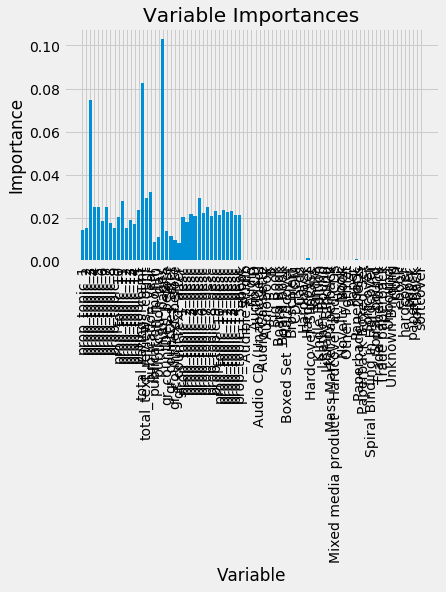

In [32]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

Verdict: All about the same

### RF w/ children 

In [35]:
y = np.array(lda_mallet_desc_genres['rating_diff'])
x = lda_mallet_desc_genres.drop('asin', axis=1).drop('rating_diff', axis=1)
x = x.drop(['biography', 'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historicalfiction', 'history', 'mystery',
            'non-fiction', 'paranormal', 'poetry', 'romance', 'thriller', 'young-adult'], axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
model = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                             max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.1629021102993636
Mean Squared Error: 0.05257389961930385
Root Mean Squared Error: 0.22928999022919394
R2 Adjusted Score: 0.5349041739838261
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2216904359317382
Mean Squared Error: 0.09056946000675457
Root Mean Squared Error: 0.3009476034241751
R2 Adjusted Score: 0.1546244529536227


# Xgboost

### Xgb w/ numeric

In [43]:
lda_mallet_numeric_all = lda_mallet.drop(['cleaned_genres', 'format'], axis=1) 
lda_mallet_numeric_all.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff'],
      dtype='object')

In [44]:
y = np.array(lda_mallet_numeric_all['rating_diff'])
x = lda_mallet_numeric_all.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.20131859178735026
Mean Squared Error: 0.07557790454916063
Root Mean Squared Error: 0.2749143585721936
R2 Adjusted Score: 0.3210538388269869
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22875743438483231
Mean Squared Error: 0.10018377868728945
Root Mean Squared Error: 0.31651821225213794
R2 Adjusted Score: 0.12958134350464867


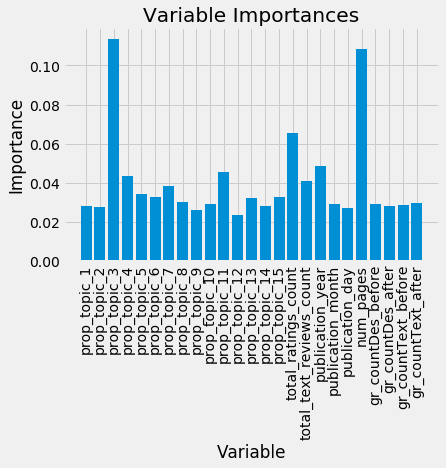

In [45]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### Xgb w/ desc

In [40]:
lda_mallet_desc_numeric_all = lda_mallet_desc.drop(['cleaned_genres', 'format'], axis=1) 
lda_mallet_desc_numeric_all.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff', 'prop_topic_1_desc',
       'prop_topic_2_desc', 'prop_topic_3_desc', 'prop_topic_4_desc',
       'prop_topic_5_desc', 'prop_topic_6_desc', 'prop_topic_7_desc',
       'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc',
       'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc',
       'prop_topic_14_desc', 'prop_topic_15_desc'],
      dtype='object')

In [41]:
y = np.array(lda_mallet_desc_numeric_all['rating_diff'])
x = lda_mallet_desc_numeric_all.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19533640319629242
Mean Squared Error: 0.07120904886348448
Root Mean Squared Error: 0.26685023676864983
R2 Adjusted Score: 0.36215016817690016
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22610235783715738
Mean Squared Error: 0.09718906910477264
Root Mean Squared Error: 0.31175161443811744
R2 Adjusted Score: 0.1392838604811687


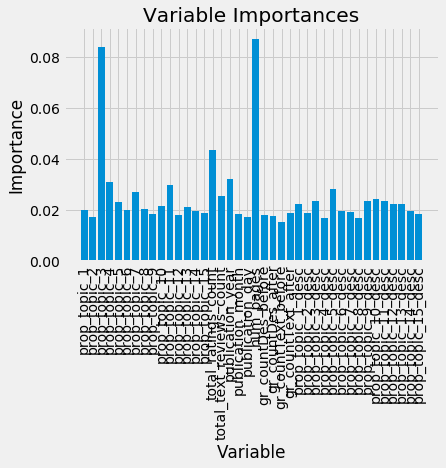

In [42]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### Xgb w/ genres

In [46]:
lda_mallet_desc_genres_all = lda_mallet_desc_numeric_all
lda_mallet_desc_genres_all = pd.merge(lda_mallet_desc_genres_all, genres, how='left', on='asin')
lda_mallet_desc_genres_all.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff', 'prop_topic_1_desc',
       'prop_topic_2_desc', 'prop_topic_3_desc', 'prop_topic_4_desc',
       'prop_topic_5_desc', 'prop_topic_6_desc', 'prop_topic_7_desc',
       'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc',
       'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc',
       'prop_topic_14_desc', 'prop_topic_15_desc', 'biography', 'children',
       'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historicalfiction',
  

In [47]:
y = np.array(lda_mallet_desc_genres_all['rating_diff'])
x = lda_mallet_desc_genres_all.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19479335208189633
Mean Squared Error: 0.07096099679008018
Root Mean Squared Error: 0.266385053616152
R2 Adjusted Score: 0.36398911036584014
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2248134602803814
Mean Squared Error: 0.09674953432699887
Root Mean Squared Error: 0.3110458717408075
R2 Adjusted Score: 0.1416212144180008


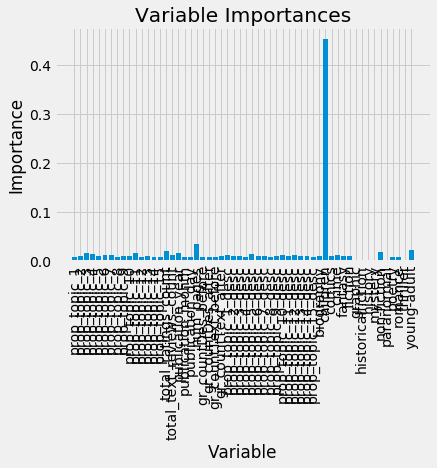

In [48]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### Xgb w/ format

In [49]:
lda_mallet_desc_format_all = lda_mallet_desc_numeric_all
lda_mallet_desc_format_all = pd.merge(lda_mallet_desc_format_all, form, how='left', on='asin')
lda_mallet_desc_format_all.columns

Index(['asin', 'prop_topic_1', 'prop_topic_2', 'prop_topic_3', 'prop_topic_4',
       'prop_topic_5', 'prop_topic_6', 'prop_topic_7', 'prop_topic_8',
       'prop_topic_9', 'prop_topic_10', 'prop_topic_11', 'prop_topic_12',
       'prop_topic_13', 'prop_topic_14', 'prop_topic_15',
       'total_ratings_count', 'total_text_reviews_count', 'publication_year',
       'publication_month', 'publication_day', 'num_pages',
       'gr_countDes_before', 'gr_countDes_after', 'gr_countText_before',
       'gr_countText_after', 'rating_diff', 'prop_topic_1_desc',
       'prop_topic_2_desc', 'prop_topic_3_desc', 'prop_topic_4_desc',
       'prop_topic_5_desc', 'prop_topic_6_desc', 'prop_topic_7_desc',
       'prop_topic_8_desc', 'prop_topic_9_desc', 'prop_topic_10_desc',
       'prop_topic_11_desc', 'prop_topic_12_desc', 'prop_topic_13_desc',
       'prop_topic_14_desc', 'prop_topic_15_desc', ' ebook', 'Audible Audio',
       'Audio', 'Audio CD', 'Audio CD (Unabridged)', 'Audio Cassette',
       'A

In [50]:
y = np.array(lda_mallet_desc_format_all['rating_diff'])
x = lda_mallet_desc_format_all.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19511046145808283
Mean Squared Error: 0.07095515090341425
Root Mean Squared Error: 0.2663740807650291
R2 Adjusted Score: 0.3633462598019749
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22543325421412966
Mean Squared Error: 0.09693568370571412
Root Mean Squared Error: 0.31134495933885636
R2 Adjusted Score: 0.1371309575782329


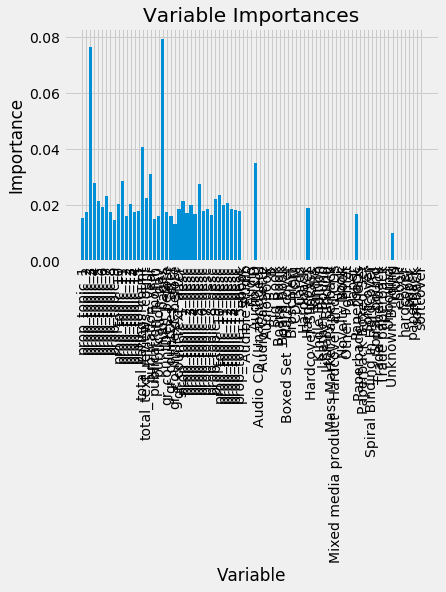

In [51]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

### Xgb w/ numeric, children, & important format

In [62]:
form.columns

Index([' ebook', 'Audible Audio', 'Audio', 'Audio CD', 'Audio CD (Unabridged)',
       'Audio Cassette', 'Audiobook', 'B', 'Big Book', 'Board Book',
       'Board book', 'Boxed Set - Hardcover', 'Broschiert', 'CD-ROM', 'Cards',
       'Hardback', 'Hardcover', 'Hardcover Slipcase', 'Kindle',
       'Kindle Edition', 'Leather Bound', 'Library Binding',
       'Mass Market Paperback', 'Mixed media product - Hardcover and CDs',
       'Nook', 'Novelty Book', 'Other Format', 'Paper', 'Paperback',
       'Paperback + 2 CDs', 'Paperback Boxed Set', 'Softcover',
       'Spiral Binding in Hardcover', 'Spiral-bound', 'Trade Paperback',
       'Trade paperback', 'Unbound', 'Unknown Binding', 'cloth', 'ebook',
       'hardcover', 'paper', 'paperback', 'softback', 'softcover', 'asin'],
      dtype='object')

In [67]:
# Find important format variables
temp = {}
for i in range(len(lda_mallet_desc_numeric_all.columns)-2, len(lda_mallet_desc_format_all.columns)-2):
    temp[features[i]] = importances[i]
sorted(temp.items(), key=lambda x: x[1], reverse=True)[:4]

[('Audio CD', 0.03499931),
 ('Hardcover', 0.018947937),
 ('Paperback', 0.016794184),
 ('Unknown Binding', 0.0101153515)]

In [75]:
y = np.array(lda_mallet_desc_format_all['rating_diff'])
x = pd.merge(lda_mallet_desc_numeric_all, lda_mallet_desc_format_all[['asin', 'Audio CD', 'Hardcover', 'Paperback',
                                                                      'Unknown Binding']], on='asin', how='right')
x = x.drop(['asin', 'rating_diff'], axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19511046145808283
Mean Squared Error: 0.07095515090341425
Root Mean Squared Error: 0.2663740807650291
R2 Adjusted Score: 0.3643287501417867
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22543325421412966
Mean Squared Error: 0.09693568370571412
Root Mean Squared Error: 0.31134495933885636
R2 Adjusted Score: 0.1411388459592562


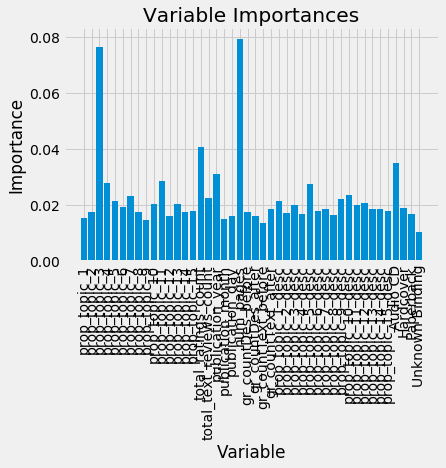

In [76]:
importances = list(model.feature_importances_)
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

# Neural Network

### NN w/ numeric

In [77]:
y = np.array(lda_mallet_numeric['rating_diff'])
x = lda_mallet_numeric.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.22921471059936596
Mean Squared Error: 0.09915982205514193
Root Mean Squared Error: 0.31489652594962353
R2 Adjusted Score: 0.12334182907273616
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22766474795255326
Mean Squared Error: 0.0954309815503956
Root Mean Squared Error: 0.3089190533948911
R2 Adjusted Score: 0.11095875183801074


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### NN w/ desc

In [78]:
y = np.array(lda_mallet_desc_numeric['rating_diff'])
x = lda_mallet_desc_numeric.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.22736911099345333
Mean Squared Error: 0.09714062897323064
Root Mean Squared Error: 0.3116739144895361
R2 Adjusted Score: 0.14067825870259576
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22845660000967988
Mean Squared Error: 0.09544927184636981
Root Mean Squared Error: 0.308948655679823
R2 Adjusted Score: 0.10918347620879754


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### NN w/ genres

In [79]:
y = np.array(lda_mallet_desc_genres['rating_diff'])
x = lda_mallet_desc_genres.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.2258062294243143
Mean Squared Error: 0.09619863504606085
Root Mean Squared Error: 0.31015904798354804
R2 Adjusted Score: 0.14846663503050783
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2262343476952451
Mean Squared Error: 0.09417814620675966
Root Mean Squared Error: 0.30688458124636964
R2 Adjusted Score: 0.11935134919805124


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### NN w/ format

In [80]:
y = np.array(lda_mallet_desc_format['rating_diff'])
x = lda_mallet_desc_format.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.2252859394309892
Mean Squared Error: 0.09518062433094326
Root Mean Squared Error: 0.3085135723609956
R2 Adjusted Score: 0.1564993866318367
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22827536985894092
Mean Squared Error: 0.0952409189694832
Root Mean Squared Error: 0.30861127485800516
R2 Adjusted Score: 0.10628900050101064


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Best Models

In [ ]:
"""
NOTE: RANKED FROM BEST TO WORST TEST PERFORMANCE

RF - NUMERIC W/ DESC & GENRES
    TRAIN DATA:
    Mean Absolute Error: 0.16252400378546364
    Mean Squared Error: 0.052339844367348676
    Root Mean Squared Error: 0.2287790295620398
    R2 Adjusted Score: 0.5366969211697463
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2212730590838635
    Mean Squared Error: 0.09026299865968647
    Root Mean Squared Error: 0.3004380113429166
    R2 Adjusted Score: 0.15596142854120454

RF - NUMERIC W/ DESC & CHILDREN
    TRAIN DATA:
    Mean Absolute Error: 0.1629021102993636
    Mean Squared Error: 0.05257389961930385
    Root Mean Squared Error: 0.22928999022919394
    R2 Adjusted Score: 0.5349041739838261
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2216904359317382
    Mean Squared Error: 0.09056946000675457
    Root Mean Squared Error: 0.3009476034241751
    R2 Adjusted Score: 0.1546244529536227
  
RF - NUMERIC W/ DESC
    TRAIN DATA:
    Mean Absolute Error: 0.16334309302784297
    Mean Squared Error: 0.05270799189504847
    Root Mean Squared Error: 0.22958221162591946
    R2 Adjusted Score: 0.5337365646662213
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2222767226635001
    Mean Squared Error: 0.09087439798098038
    Root Mean Squared Error: 0.30145380737516053
    R2 Adjusted Score: 0.15188022134593127

RF - NUMERIC
    TRAIN DATA:
    Mean Absolute Error: 0.1694112340225193
    Mean Squared Error: 0.056197375139196475
    Root Mean Squared Error: 0.2370598556044369
    R2 Adjusted Score: 0.5031668363317059
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22276636522533477
    Mean Squared Error: 0.09181105733766523
    Root Mean Squared Error: 0.30300339492762324
    R2 Adjusted Score: 0.1446822018963977
    
NN - NUMERIC W/ DESC & GENRES
    TRAIN DATA:
    Mean Absolute Error: 0.2258062294243143
    Mean Squared Error: 0.09619863504606085
    Root Mean Squared Error: 0.31015904798354804
    R2 Adjusted Score: 0.14846663503050783
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2262343476952451
    Mean Squared Error: 0.09417814620675966
    Root Mean Squared Error: 0.30688458124636964
    R2 Adjusted Score: 0.11935134919805124
    
NN - NUMERIC W/ DESC & FORMAT    
    TRAIN DATA:
    Mean Absolute Error: 0.2252859394309892
    Mean Squared Error: 0.09518062433094326
    Root Mean Squared Error: 0.3085135723609956
    R2 Adjusted Score: 0.1564993866318367
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22827536985894092
    Mean Squared Error: 0.0952409189694832
    Root Mean Squared Error: 0.30861127485800516
    R2 Adjusted Score: 0.10628900050101064
    
NN - NUMERIC
    TRAIN DATA:
    Mean Absolute Error: 0.22921471059936596
    Mean Squared Error: 0.09915982205514193
    Root Mean Squared Error: 0.31489652594962353
    R2 Adjusted Score: 0.12334182907273616
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22766474795255326
    Mean Squared Error: 0.0954309815503956
    Root Mean Squared Error: 0.3089190533948911
    R2 Adjusted Score: 0.11095875183801074

NN - NUMERIC W/ DESC
    TRAIN DATA:
    Mean Absolute Error: 0.22736911099345333
    Mean Squared Error: 0.09714062897323064
    Root Mean Squared Error: 0.3116739144895361
    R2 Adjusted Score: 0.14067825870259576
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22845660000967988
    Mean Squared Error: 0.09544927184636981
    Root Mean Squared Error: 0.308948655679823
    R2 Adjusted Score: 0.10918347620879754

XGB - NUMERIC W/ DESC & GENRES
    TRAIN DATA:
    Mean Absolute Error: 0.19479335208189633
    Mean Squared Error: 0.07096099679008018
    Root Mean Squared Error: 0.266385053616152
    R2 Adjusted Score: 0.36398911036584014
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2248134602803814
    Mean Squared Error: 0.09674953432699887
    Root Mean Squared Error: 0.3110458717408075
    R2 Adjusted Score: 0.1416212144180008

XGB - NUMERIC W/ DESC & FORMAT
    TRAIN DATA:
    Mean Absolute Error: 0.19511046145808283
    Mean Squared Error: 0.07095515090341425
    Root Mean Squared Error: 0.2663740807650291
    R2 Adjusted Score: 0.3633462598019749
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22543325421412966
    Mean Squared Error: 0.09693568370571412
    Root Mean Squared Error: 0.31134495933885636
    R2 Adjusted Score: 0.1371309575782329

XGB - NUMERIC W/ DESC
    TRAIN DATA:
    Mean Absolute Error: 0.19533640319629242
    Mean Squared Error: 0.07120904886348448
    Root Mean Squared Error: 0.26685023676864983
    R2 Adjusted Score: 0.36215016817690016
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22610235783715738
    Mean Squared Error: 0.09718906910477264
    Root Mean Squared Error: 0.31175161443811744
    R2 Adjusted Score: 0.1392838604811687

XGB - NUMERIC
    TRAIN DATA:
    Mean Absolute Error: 0.20131859178735026
    Mean Squared Error: 0.07557790454916063
    Root Mean Squared Error: 0.2749143585721936
    R2 Adjusted Score: 0.3210538388269869
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.22875743438483231
    Mean Squared Error: 0.10018377868728945
    Root Mean Squared Error: 0.31651821225213794
    R2 Adjusted Score: 0.12958134350464867
    
"""

# Ensemble

In [84]:
model1 = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                               max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model2 = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model3= MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)

y = np.array(lda_mallet_desc_genres['rating_diff'])
x = lda_mallet_desc_genres.drop('asin', axis=1).drop('rating_diff', axis=1)
x = x.drop(['biography', 'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historicalfiction', 'history', 'mystery',
            'non-fiction', 'paranormal', 'poetry', 'romance', 'thriller', 'young-adult'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_nn = scaler.transform(x_train)
x_test_nn = scaler.transform(x_test)

model3.fit(x_train_nn, y_train)

# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((34*model1_pred) + (33*model2_pred) + (33*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((34*model1_pred) + (33*model2_pred) + (33*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


TRAIN DATA:
Mean Absolute Error: 0.1919690674001756
Mean Squared Error: 0.07085381374659366
Root Mean Squared Error: 0.26618379692722405
R2 Adjusted Score: 0.3731906274883159
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22084391122845934
Mean Squared Error: 0.09021185474119416
Root Mean Squared Error: 0.3003528836904919
R2 Adjusted Score: 0.15796234132103992


In [85]:
model1 = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                               max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model2 = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model3= MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)

y = np.array(lda_mallet_desc_genres['rating_diff'])
x = lda_mallet_desc_genres.drop('asin', axis=1).drop('rating_diff', axis=1)
x = x.drop(['biography', 'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historicalfiction', 'history', 'mystery',
            'non-fiction', 'paranormal', 'poetry', 'romance', 'thriller', 'young-adult'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_nn = scaler.transform(x_train)
x_test_nn = scaler.transform(x_test)

model3.fit(x_train_nn, y_train)

# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((50*model1_pred) + (25*model2_pred) + (25*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((34*model1_pred) + (33*model2_pred) + (33*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


TRAIN DATA:
Mean Absolute Error: 0.18431618952885534
Mean Squared Error: 0.06581713304618307
Root Mean Squared Error: 0.2565485003779657
R2 Adjusted Score: 0.4177477021527386
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2208399440794553
Mean Squared Error: 0.09017126069686575
Root Mean Squared Error: 0.30028529883573346
R2 Adjusted Score: 0.15834124622373447


In [86]:
model1 = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                               max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model2 = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model3= MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)

y = np.array(lda_mallet_desc_genres['rating_diff'])
x = lda_mallet_desc_genres.drop('asin', axis=1).drop('rating_diff', axis=1)
x = x.drop(['biography', 'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historicalfiction', 'history', 'mystery',
            'non-fiction', 'paranormal', 'poetry', 'romance', 'thriller', 'young-adult'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_nn = scaler.transform(x_train)
x_test_nn = scaler.transform(x_test)

model3.fit(x_train_nn, y_train)

# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((60*model1_pred) + (20*model2_pred) + (20*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((34*model1_pred) + (33*model2_pred) + (33*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


TRAIN DATA:
Mean Absolute Error: 0.17997814723160085
Mean Squared Error: 0.06300894114031935
Root Mean Squared Error: 0.2510158185061638
R2 Adjusted Score: 0.44259041580965086
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22044957592901854
Mean Squared Error: 0.09002848664909682
Root Mean Squared Error: 0.30004747399219484
R2 Adjusted Score: 0.15967389951246636


In [ ]:
Verdict: Ensemble gave slightly better results